The pre-processing / feature extraction has three main options:
1. Which layers do we use? We can take any layer or combination of layers as features. Default options are the final 4 (8--12, exc.) and the before-last one (10--11, exclusive).

2. How to summarize the layers, if they're more than one? Right now, this is not a param, it's by default mean. Some papers also report max. See also this paper: https://arxiv.org/abs/1905.05583

3. How to summarize the word-x-word softmax-attention scores. There's several options:
- 1. CLS token horizontal axis [CLS-1], doesn't work.
- 2. CLS token vertical axis [CLS-2], works.
- 3. All tokens on horizontal axis, sum over tokens [sum-1], doesn't work.
- 4. All tokens on vertical axis, sum over tokens / horizontal axis [sum-2], works.

These are coded as 1-2-3-4. Furthermore, the different heads (12 in total) need to be summarized, either through:
- 1. mean
- 2. max

These are coded as 1-2-3-4 + mean.

4. Two feature sets are extracted: With or without an attention-weighted average.

In [1]:
PARAMS = {
    'MODEL': "bert-base-uncased",
    'LAYER': [10,11], 
    # either [10,11] (exclusive on 11, so layer #10, for before-last layer, see output below) 
    # or [8,12] (for sum of last four layers, exlusive on 12, so layers #8--11)
    'ATTENTION_METHOD': "2-mean",
    # Wich stats method and score option to take? (4-max or 2-mean)
    # max-4 is probably the best, as 2-mean uses the CLS token which can be quite "out of reach" given the windows
    # or at least, more ambiguous / dependent on the window
    # still... could be good to test both
}

import numpy as np
l = np.arange(0,12) # 11 is max
print("LAYERS: ", l[slice(min(PARAMS['LAYER']),max(PARAMS['LAYER']))])

LAYERS:  [10]


### Extract layer

(Image from [Jay Allamar](http://jalammar.github.io/illustrated-bert/)'s blog)

![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)


In [2]:
import pandas as pd
import os
import glob
from nltk import tokenize

def load_wiki(my_dir):
    data = []

    # Step 2: Build up list of files:
    for file in os.listdir(my_dir):
        if file.endswith(".txt"):
            name, ext = os.path.splitext(file)
            # Open a file: file
            f = open(my_dir + file,mode='r')
            # read all lines at once
            all_of_it = f.read()
            # close the file
            f.close()
            data.append({
                'id': name,
                'label': 1 if 'english' in my_dir else 0, # english = 1, simple = 0
                'text': all_of_it
            })
            # split into sentences
            #sens = tokenize.sent_tokenize(all_of_it)
            #for sen in sens:
            #    data.append({
            #        'id': name,
            #        'label': 1 if 'english' in my_dir else 0, # english = 1, simple = 0
            #        'text': sen
            #    })
    return data
    
# Step 1: get a list of all csv files in target directory
en_wiki = load_wiki('/home/frans/farm/share/com1/vec2read/ensiwiki_2020-agerank-50k/articles/raw/english/')
si_wiki = load_wiki('/home/frans/farm/share/com1/vec2read/ensiwiki_2020-agerank-50k/articles/raw/simple/')

df = pd.DataFrame( en_wiki + si_wiki )
df["page_id"] = df["id"].str.split("_").str[1].astype('int64')
df["wiki_id"] = df["id"].str.split("_").str[2].astype('int64')
pairs_df = pd.read_csv("/home/frans/farm/share/com1/wiki_pairs.csv")
pairs_df.rename(columns = {'id':'pair_id'}, inplace = True)
#pairs_df.head()
df = pd.concat([pd.merge(df[df["label"] == 0], pairs_df, left_on="wiki_id", right_on="simple_id"),
    pd.merge(df[df["label"] == 1], pairs_df, left_on="wiki_id", right_on="english_id")])
df

,id,label,text,page_id,wiki_id,pair_id,simple_id,english_id
0,simple_58159_237530_0,0,The Battles of Lexington and Concord were the ...,58159,237530,58159,237530,4321886
1,simple_18299_69488_0,0,"Saburo Sakai (, Sakai Saburō, August 25, 1916 ...",18299,69488,18299,69488,336344
2,simple_72948_317686_0,0,Flowers and candles on Wenceslas Square in Nov...,72948,317686,72948,317686,148283
3,simple_2414_7865_0,0,Disgust is an emotion. People feel it when the...,2414,7865,2414,7865,22499522
4,simple_39746_152802_0,0,A natural language is the kind which we use in...,39746,152802,39746,152802,21173
...,...,...,...,...,...,...,...,...
25206,english_84060_74547_0,1,The Roanoke Colony () refers to two attempts b...,84060,74547,84060,371753,74547
25207,english_2359_31045316_0,1,"National Socialism (), more commonly known as ...",2359,31045316,2359,7749,31045316
25208,english_19750_1447684_0,1,Jaya Sri Maha Bodhi (Sinhala: ජය ශ්‍රී මහා බොධ...,19750,1447684,19750,76611,1447684
25209,english_9939_53273_0,1,Duke University is a private research universi...,9939,53273,9939,34512,53273


In [3]:
import torch


# Take either -2 (before-last), or another, or a sum
# assumes layers are 0th dimension of output
def extract_layer(output):
    """
    Extracts a layer or sum of layers from Bert's outputs.

    Args:
        output (tensor): Tuple of output tensors returned by Bert model.
        layer_idx (int or tuple): Index of layer(s) to extract or sum.

    Returns:
        tensor: Extracted layer tensor or sum of layer tensors.
    """
    debug = False
    if debug: print(output.size())
    layer_idx = PARAMS['LAYER']
    if isinstance(layer_idx, int):
        # Extract single layer
        return output[layer_idx]

    elif isinstance(layer_idx, range):
        # Sum of layers
        return torch.sum(output[layer_idx], dim=0)

    import torch

    
def extract_layer_dim(outputs, dim=-1, layer_idx = PARAMS['LAYER']):
    """
    Extract or sum a range of layers from a tensor of any shape.
    
    Args:
        outputs (torch.Tensor): Output tensor from BERT model.
        PARAMS['LAYER'] ([int]): Indexes of the first layer to extract or sum.
        num_layers (int, optional): Number of layers to extract or sum (default=1).
        dim (int, optional): Dimension on which to extract or sum layers (default=-1).
    
    Returns:
        torch.Tensor: Tensor with the desired layers extracted or summed.
    """
    debug = False
    num_layers = max(layer_idx) - min(layer_idx)
    if num_layers < 1:
        raise Exception("Only PARAMS['LAYER'] with at least two values are supported")
    layer_slice = slice(min(layer_idx), max(layer_idx))
    layer_shape = list(outputs.shape)
    layer_shape[dim] = num_layers
    if debug: 
        print(layer_shape)
        print(dim)
    
    if dim < 0:
        dim += len(layer_shape)
        
    layer_slice = [slice(None)] * dim + [layer_slice] + [slice(None)] * (len(layer_shape) - dim - 1)

    if debug:
        print(layer_slice)
        print(layer_idx)
    
    if num_layers > 1:
        return torch.sum(outputs[layer_slice], dim=dim)
    else:
        return outputs[layer_slice].squeeze(dim=dim)


Input ids: [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 102, 1996, 13971, 3899, 1010, 24720, 2011, 1996, 4248, 2829, 4419, 1010, 7771, 21614, 1012, 102]
Initial attention size: torch.Size([12, 1, 12, 26, 26])
After selecting before-last layer: torch.Size([1, 12, 26, 26])
After selecting first batch: torch.Size([12, 26, 26])
After mean/max over heads: torch.Size([26, 26])


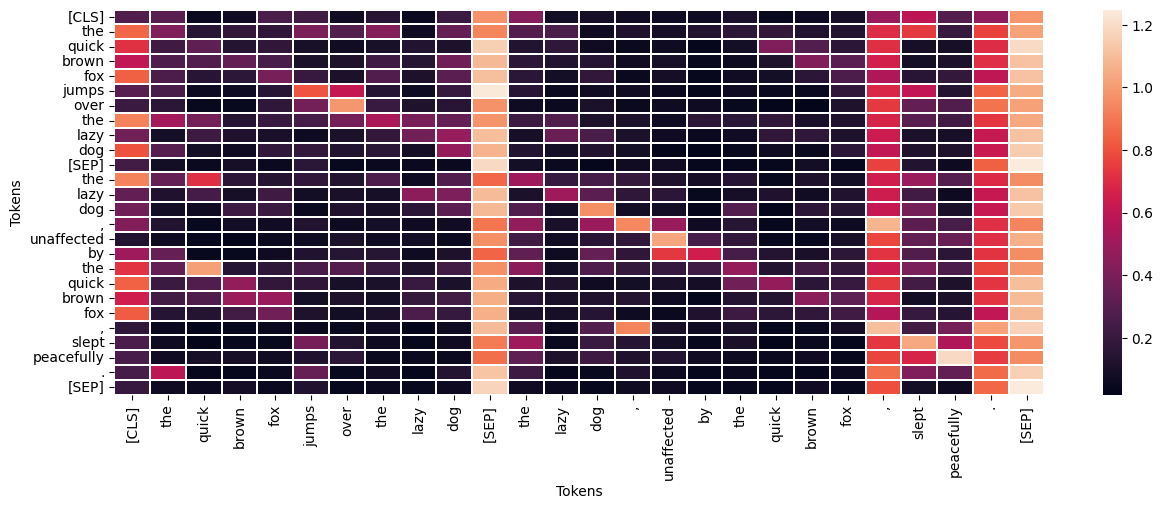

option 1 sum: tensor(6.5677, device='cuda:0')
option 2 sum: tensor(12.9976, device='cuda:0')
option 3 sum: tensor(200.4820, device='cuda:0')
option 4 sum: tensor(200.4820, device='cuda:0')


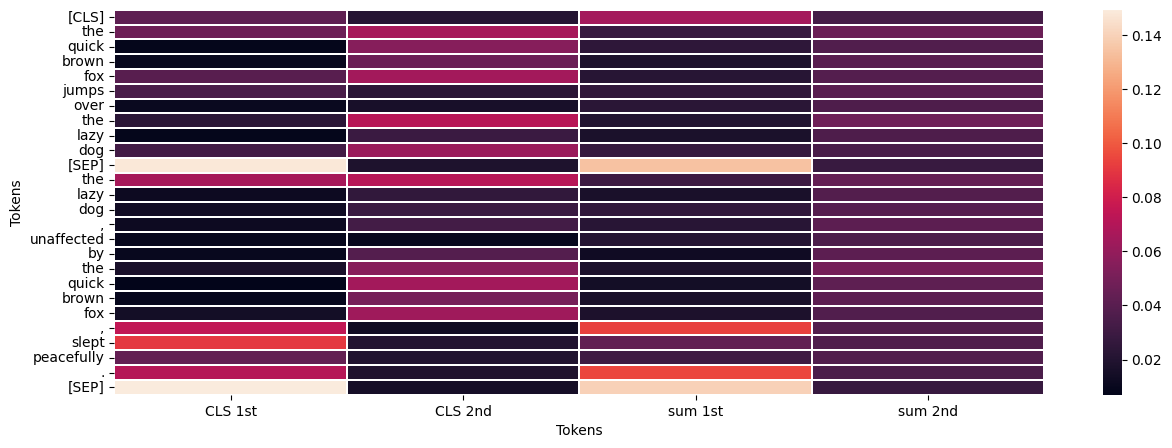

[CLS]: (CLS 2nd) 0.0211, (sum 2nd) 0.0328
the: (CLS 2nd) 0.0656, (sum 2nd) 0.0461
quick: (CLS 2nd) 0.0552, (sum 2nd) 0.0373
brown: (CLS 2nd) 0.0464, (sum 2nd) 0.0402
fox: (CLS 2nd) 0.0645, (sum 2nd) 0.0384
jumps: (CLS 2nd) 0.0231, (sum 2nd) 0.0399
over: (CLS 2nd) 0.0159, (sum 2nd) 0.0365
the: (CLS 2nd) 0.0714, (sum 2nd) 0.0474
lazy: (CLS 2nd) 0.0287, (sum 2nd) 0.0361
dog: (CLS 2nd) 0.0620, (sum 2nd) 0.0346
[SEP]: (CLS 2nd) 0.0183, (sum 2nd) 0.0282
the: (CLS 2nd) 0.0715, (sum 2nd) 0.0440
lazy: (CLS 2nd) 0.0257, (sum 2nd) 0.0380
dog: (CLS 2nd) 0.0290, (sum 2nd) 0.0387
,: (CLS 2nd) 0.0322, (sum 2nd) 0.0410
unaffected: (CLS 2nd) 0.0099, (sum 2nd) 0.0354
by: (CLS 2nd) 0.0384, (sum 2nd) 0.0410
the: (CLS 2nd) 0.0556, (sum 2nd) 0.0495
quick: (CLS 2nd) 0.0648, (sum 2nd) 0.0419
brown: (CLS 2nd) 0.0501, (sum 2nd) 0.0411
fox: (CLS 2nd) 0.0637, (sum 2nd) 0.0373
,: (CLS 2nd) 0.0132, (sum 2nd) 0.0379
slept: (CLS 2nd) 0.0202, (sum 2nd) 0.0366
peacefully: (CLS 2nd) 0.0196, (sum 2nd) 0.0370
.: (CLS 2nd)

In [4]:
import torch
from transformers import BertModel, BertConfig, BertTokenizer
import seaborn as sns
import matplotlib.pyplot as plt


# Load pre-trained model tokenizer and model
if("bert-base-uncased"==PARAMS['MODEL']):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True, return_dict=True)
    model = BertModel.from_pretrained('bert-base-uncased', config=config).to("cuda:0")

# Define input text
text = "The quick brown fox jumps over the lazy dog. The lazy dog, unaffected by the quick brown fox, slept peacefully."

# Tokenize sentences
sentences = text.split('. ')
sentences_tokens = [tokenizer.encode(sent, add_special_tokens=False) + [tokenizer.sep_token_id] for sent in sentences]

# Concatenate sentences into a single sequence
input_ids = [tokenizer.cls_token_id] + [token for sent in sentences_tokens for token in sent][:510]
print("Input ids:", input_ids)

# Encode input sequence using BERT tokenizer
input_tokens = torch.tensor(input_ids).to("cuda:0").unsqueeze(0)
with torch.no_grad():
    outputs = model(input_tokens)
    features = outputs[0][:, 1:-1, :]  # Exclude [CLS] and [SEP] tokens from features
    avg_features = torch.mean(features, dim=1)  # Average features over tokens

# Print the features for the concatenated sequence
#print(avg_features)


attentions = torch.stack(outputs.attentions) # this will give the attentions
# From the docs:
# attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or 
# when config.output_attentions=True) — Tuple of torch.FloatTensor (one for each layer) 
# of shape (batch_size, num_heads, sequence_length, sequence_length).
# Attentions weights after the attention softmax, used to compute the 
# weighted average in the self-attention heads.
# https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.BaseModelOutput
print("Initial attention size:", attentions.size())

# First, take the before-last layer
# layers x batches x heads x tokens x tokens = softmax
attentions = extract_layer_dim(attentions, dim=0)
print("After selecting before-last layer:", attentions.size())
# Second, take first batch
# batches x heads x tokens x tokens = softmax
attentions = attentions[0]
print("After selecting first batch:", attentions.size())
# Third, summarize over heads
# heads x tokens x tokens = softmax
# either mean or max?
attentions_mean = torch.mean(attentions, dim=0)
attentions_max = torch.max(attentions, dim=0).values
attentions = attentions_max
print("After mean/max over heads:", attentions.size())

# Now we have the softmax values for each token-token comparison
# tokens x tokens = softmax
# meaning how much token a attends to token b
# or, vice versa, how much token b is attended to by token a
# Let's visualize:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=tokenizer.convert_ids_to_tokens(input_ids)
yticklabels=tokenizer.convert_ids_to_tokens(input_ids)
ax = sns.heatmap(attentions.cpu().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.show()
    
# Let's compare three different methods for flattening
# the tokens x tokens = softmax matrix
# Option 1: CLS token (1st dimension, top row in figure)
option_1 = torch.nn.functional.normalize(attentions[0,:], p=1, dim=0)
# Option 2: CLS token (2nd dimension, left column in figure)
option_2 = torch.nn.functional.normalize(attentions[:,0], p=1, dim=0)
# Option 3: sum-of "attention given"
option_3 = torch.nn.functional.normalize(torch.mean(attentions, dim=0), p=1, dim=0) # only ones!
# Option 4: sum-of "attention received"
option_4 = torch.nn.functional.normalize(torch.mean(attentions, dim=1), p=1, dim=0) # only ones!
print("option 1 sum:", torch.sum(attentions[0,:], dim=0)) # 1.0 with attention_mean
print("option 2 sum:", torch.sum(attentions[:,0], dim=0)) # 1.8 with attention_mean
print("option 3 sum:", torch.sum(torch.sum(attentions, dim=0))) # 26.0 (all ones?) with attention_mean
print("option 4 sum:", torch.sum(torch.sum(attentions, dim=1))) # 26.0 (all ones?) with attention_mean
#print("option 4 vector:", torch.sum(attentions, dim=1)) # all ones! 26.0 with attention_mean


# Plot again
flattened = torch.stack([option_1, option_2, option_3, option_4], 1) # 
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=["CLS 1st", "CLS 2nd", "sum 1st", "sum 2nd"]
yticklabels=tokenizer.convert_ids_to_tokens(input_ids)
ax = sns.heatmap(flattened.cpu().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.show()

# https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1

# Compute importance scores for each token
# computes the importance scores for each token by summing the attention weights
# across all output heads and taking the maximum attention weight across all heads.

# Print importance scores for each token
for i,token in enumerate(tokenizer.convert_ids_to_tokens(input_ids)):
    print(f"{token}: (CLS 2nd) {option_2[i]:.4f}, (sum 2nd) {option_4[i]:.4f}")
    

In [5]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

# Load pre-trained model and tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = BertModel.from_pretrained('bert-base-uncased')

# Define sliding window size and stride
window_size = 12
stride = 6

# Define function to extract features from sliding window
def extract_features(text):
    debug = False
    # Tokenize text
    sentences = text.split('.')
    tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in sentences]
    tokens = [token for sentence in tokenized_sentences for token in sentence]
    
    # Apply sliding window and extract features
    features = []
    for i in range(0, len(tokens), stride):
        window = tokens[i:i+window_size]
        if len(window) < window_size:
            window += ['[PAD]'] * (window_size - len(window))
        if (debug): print(window)
        input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(window)]).to("cuda:0")
        with torch.no_grad():
            outputs = model(input_ids)
            #last_hidden_states = outputs[0][:, -2, :]
            #last_hidden_states = torch.sum(outputs[0][:, 8:12, :], dim=1)
            #print(outputs[0][:, 8:12, :].size())
            last_hidden_states = extract_layer_dim(outputs[0], dim=1) 
            #print(last_hidden_states.size())
            features.append(torch.mean(last_hidden_states, dim=0))
    
    return torch.stack(features, dim=0)

# Example usage
text = "This is a long document. It contains many sentences. Some sentences are quite long, while others are short. The document will be split into sliding windows to extract features with BERT."
features = extract_features(text)
features.size()
doc_vec = torch.mean(features, dim=0)
print(doc_vec.size())
print(doc_vec[0:10])
del doc_vec
del features

torch.Size([768])
tensor([-0.2049,  0.4041,  0.3979,  0.3488,  1.7499, -0.4395, -0.5632, -1.1326,
        -0.4900, -0.1641], device='cuda:0')


### Text encoder (transforms text into input_ids)
First does a sentence split
Then tokenizes the sentences (input_ids)
Then concatenates the sentences again
Note: This removes the leading [CLS] token but includes the trailing [SEP] tokens after each sentence

In [6]:
from nltk import sent_tokenize
# Tokenize text

def encode_text(text, debug=False):
    sentences = sent_tokenize(text)
    tokenized_sentences = [tokenizer.encode(sentence) for sentence in sentences]
    if debug and any(len(sent) > 512 for sent in tokenized_sentences):
        print("Note: One sentence was longer than the max-allowed length. Ignore this + related pytorch warning.")
    # drop CLS tokens at beginning
    tokenized_sentences = [sentence[1:] for sentence in tokenized_sentences]
    tokens = [token for sentence in tokenized_sentences for token in sentence]
    #tokens_with_cls = [tokenizer.cls_token_id] + tokens
    #print(tokens)

    lengths = [len(sentence) for sentence in tokenized_sentences]
    positions = [sum(lengths[0:j]) for j in range(len(lengths))]
    #print("Tokens length: ", len(tokens))
    #print("Lengths:", lengths)
    #print("Positions", positions)
    #print("Tokens: ", tokenizer.convert_ids_to_tokens(tokens))
    #print("Sentence starts", [tokens[i] for i in positions]) # start of each sentence, all zeros
    #print("Sentence ends", [tokens[i-1] for i in positions]) # end of each sentence, all twos
    #np_lengths[index] = len(tokens)
    #print("Tokens length after truncation: ", len(tokens))

    input_ids = torch.tensor(tokens).to("cuda:0")#.unsqueeze(0)  # batch of size 1
    return(input_ids)

text = "This is a long document. It contains many sentences. Some sentences are quite long, while others are short. The document will be split into sliding windows to extract features with BERT."
encode_text(text)

tensor([ 2023,  2003,  1037,  2146,  6254,  1012,   102,  2009,  3397,  2116,
        11746,  1012,   102,  2070, 11746,  2024,  3243,  2146,  1010,  2096,
         2500,  2024,  2460,  1012,   102,  1996,  6254,  2097,  2022,  3975,
         2046,  8058,  3645,  2000, 14817,  2838,  2007, 14324,  1012,   102],
       device='cuda:0')

### Window goodies

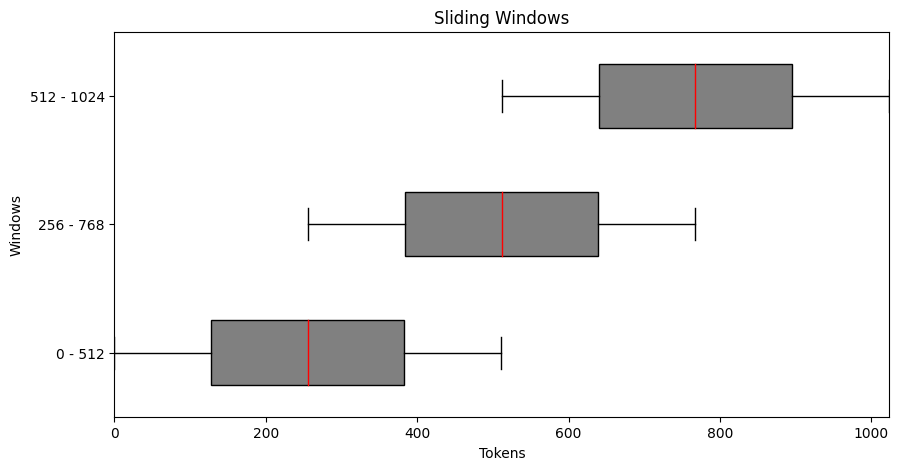

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create example sequence of tokens
tokens = np.arange(1024)

# Define window parameters
window_size = 512
stride = 256
overlap = 128

# Compute the number of windows
num_windows = ((len(tokens) - window_size) // stride) + 1

# Initialize an array to hold the window data
windows = np.zeros((num_windows, window_size))

# Populate the window data array
for i in range(num_windows):
    start = i * stride
    end = start + window_size
    windows[i] = tokens[start:end]

# Compute the boxplot data for each window
boxplot_data = []
for i in range(num_windows):
    start = i * stride
    end = start + window_size
    window = tokens[start:end]
    boxplot_data.append(window)

# Create the boxplot
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(boxplot_data, vert=False, widths=0.5, patch_artist=True,
           boxprops=dict(facecolor='gray', color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           medianprops=dict(color='red'))

# Set the y-axis tick labels to show the start and end token indices for each window
yticks = np.arange(num_windows) + 1
yticklabels = [f'{i * stride} - {(i * stride) + window_size}' for i in range(num_windows)]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

# Set the x-axis limits to show the full range of tokens
ax.set_xlim(0, len(tokens))

# Set the axis labels and title
ax.set_xlabel('Tokens')
ax.set_ylabel('Windows')
ax.set_title('Sliding Windows')

# Show the plot
plt.show()


In [8]:
import math
import numpy as np

# Define the window size and stride
window_size = 510
stride = int(window_size/2)
overlap = int(stride/2)

# Sliding window functions
def sliding_window(length, window_size, stride, debug=False):
    length = length-1 
    # cause the following seq is inclusive, 
    # eg [0,1] has max 1 but length 2
    seq = np.arange(length + stride - length % stride)
    if debug: print(seq)
    # Calculate the number of windows
    num_windows = ((len(seq) - window_size) // stride) + 1
    if debug: print(length,"+",stride - length % stride,"; num_windows=",num_windows,"; len(seq)=",len(seq))
    # Use stride_tricks.as_strided to create a sliding window view of the sequence
    window_view = np.lib.stride_tricks.as_strided(
        seq,
        shape=(num_windows, window_size),
        strides=(seq.strides[0]*stride, seq.strides[0])
    )
    return(window_view)

# Transforming window (range) into seperate ranges for the 
# window (max text length) and tokens (- / + a quarter of the window,
# except at start/end of text)
def window_ranges(windows, window, text_length, is_start=False, debug=False):
    # is_end=False, 
    is_end = max(window)+1>=text_length 
    # the +1 is because window = range of positions, and length is a count.
    # eg [0,1] has max 1 but length 2
    # is_start tells that this is the first window, check with i==0
    left = 0 if is_start else min(window)+overlap
    # text_length minus one, cause we're dealing with indexes here
    right = text_length if is_end else max(window)-overlap
    #token_ids = tokens.cpu().numpy()[left:right]
    window_left = min(window)
    window_right = min(window_left+window_size, text_length)
    window_range = range(window_left, window_right)
    token_range = range(left, right)
    # debug
    if debug:
        #" end="+str(is_end)+
        win_str = "window start="+str(is_start)+";end="+str(is_end)+": "+str(min(window))+"--"+str(max(window))
        select_str = "select: "+str(left)+"--"+str(right)+", len:"+str(right-left)
        padding_str = "tokens:"+str(window_left)+"--"+str(window_right) #+" i="+str(index)+"/"+str(len(windows))
        print("{:<20}\t{:<25}\t{}".format(win_str, select_str, padding_str))
    return (window_range, token_range)
    # window_range counts till window_size (510), except at the end of the text
    # select_range is only the selected tokens in the middle, which excludes 
    # a quarter of the window on each side

## A test run
# change params for further testing
text_length = 765 # 1024
print(text_length + stride)
print(text_length % stride)
#text length: 117 ; window_size:  510 ; stride: 255 ; overlap: 127
window_view = sliding_window(text_length, window_size, stride)
if text_length<=window_size:
    window_view = [range(0,window_size)]

for i,window in enumerate(window_view):
    window_ranges(window_view, window, text_length, is_start=i==0, debug=True)
    # is_end=i==len(window_view)-1,

1020
0
window start=True;end=False: 0--509	select: 0--382, len:382  	tokens:0--510
window start=False;end=True: 255--764	select: 382--765, len:383	tokens:255--765


### Turning text into batch of input_id blocks/windows

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the input sequence
text = df.iloc[8].text
tokens = encode_text(text)
text_length = tokens.shape[0]
print("text length:",text_length,"; window_size: ",window_size,"; stride:",stride,"; overlap:",overlap)

# Iterate over the sliding windows
window_view = sliding_window(text_length, window_size, stride)
if text_length<=window_size:
    window_view = [range(0,window_size)]

# Apply sliding windows to tokens
# the resulting list is in numpy - otherwise pad_sequences doesn't accept it
def tokens_to_batches(tokens, window_view, debug=False):
    list_of_inputs = []
    for i,window in enumerate(window_view):
        (window_range, token_range) = window_ranges(window_view, window, text_length=tokens.shape[0], is_start=(i==0), debug=debug)
        # , is_end=(i==len(window_view)-1)
        token_ids = tokens.cpu().numpy()[min(window_range):max(window_range)] # whole window
        # always start with [CLS]
        tokens_with_cls = np.insert(token_ids, 0, tokenizer.cls_token_id)
        # end with [SEP], unless there's already a [SEP] token
        tokens_with_sep = tokens_with_cls if tokens_with_cls[-1]==tokenizer.sep_token_id else np.append(tokens_with_cls, tokenizer.sep_token_id)

        #print(len(token_ids), len(tokens_with_cls), len(tokens_with_sep))
        #print(tokenizer.convert_ids_to_tokens(tokens_with_sep))
        input_ids = tokens_with_sep #torch.tensor(tokens_with_sep).to("cuda:0")  # batch of size 1
        list_of_inputs.append(input_ids)

    input_ids_padded = pad_sequences(list_of_inputs, maxlen=512, padding='post', truncating='post', value=tokenizer.pad_token_id)
    return(input_ids_padded)

input_ids_padded = tokens_to_batches(tokens, window_view, debug=True)
print(input_ids_padded.shape)
input_ids_padded


text length: 761 ; window_size:  510 ; stride: 255 ; overlap: 127
window start=True;end=False: 0--509	select: 0--382, len:382  	tokens:0--510
window start=False;end=True: 255--764	select: 382--761, len:379	tokens:255--761
(2, 512)


array([[  101, 12667,  2015, ...,  2550,   102,     0],
       [  101,  2478, 12667, ...,     0,     0,     0]], dtype=int32)

### Convertings input_ids into document embedding
Selecting a layer from the hidden states/layers
And applying a mean pooling method over all token-embeddings

In [10]:

# convert the padded input_ids to a PyTorch tensor
input_ids_tensor = torch.tensor(input_ids_padded).to("cuda:0")

#from transformers import BertModel, BertConfig
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True, return_dict=True)
#config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True)
#model = BertModel.from_pretrained('bert-base-uncased', config=config)

# run the batch on Bert
outputs = model(input_ids_tensor)
print(len(outputs))  # 3

# x windows, y tokens, z nodes
print("outputs[0]", outputs[0].size())

# x windows, y nodes
print("outputs[1]", outputs[1].size()) 

all_hidden_states = torch.stack(outputs[2])
# 13 layers, x batches/windows, y tokens, z nodes
print("outputs[2]", all_hidden_states.size())
# x batches/windows, y tokens, z nodes

# 12 layers!
print("outputs[3]", torch.stack(outputs[3]).size())

def extract_document_embedding(all_hidden_states, window_view, text_length, includes_start=True, includes_end=True, layer_idxs = PARAMS['LAYER'], debug=False):
    # layer_index+1 as we have 13 layers (embedding + num of blocks)
    layer_idx = [l+1 for l in layer_idxs]
    if debug: print("layer_idx:",layer_idx)
    layer = extract_layer_dim(all_hidden_states, dim=0, layer_idx=layer_idx)
    #layer_index = 11 # second to last hidden layer -> wrong! that's the last layer...
    #print(all_hidden_states[12].size()) < last layer (given the extra layer that's here)
    # print(all_hidden_states[13].size()) < gives an error
    #layer = all_hidden_states[layer_index+1, :, :, :] 
    if debug: print("layer_size:", layer.size())
    # layer_index+1 as we have 13 layers (embedding + num of blocks)
    
    # Prepare reanges
    is_start = lambda i: (i==0 and includes_start)
    #is_end = lambda i: (i==len(window_view)-1 and includes_end)
    ranges = [window_ranges(window_view, window, text_length, is_start(i), debug=debug) for i,window in enumerate(window_view)]
    # is_end(i), 
    select_min = min([min(w[1]) for w in ranges])
    select_max = max([max(w[1]) for w in ranges])
    #assert select_max-select_min+1==text_length, "mismatch between numbers of tokens selected and text_length given"
    #text_length = select_max-select_min+1
    # text_length is the maximum length of the text, thus equals select_max
    # local_length = the number of tokens analyzed here
    local_length = select_max-select_min+1
    if debug: print("select_min:",select_min,"; select_max:",select_max,"; max-min+1:",select_max-select_min+1,"; text_length:",text_length, "; local_length:",local_length)

    # tokens x nodes
    matrix = np.zeros((local_length, 768))
    check = np.zeros(local_length)
    for i,(window_range,token_range) in enumerate(ranges):
        window_left = min(window_range)
        window_right = max(window_range)
        select_left = min(token_range) - window_left
        select_right = max(token_range)+1 - window_left
        window_str = "window: "+str(window_left)+"--"+str(window_right)+", len:"+str(window_right-window_left+1)
        select_str = "select: "+str(select_left)+"--"+str(select_right)+", len:"+str(select_right-select_left)
        if debug:
            print(window_str)
            print(select_str)
            print(str(i), layer[i, :, :].size())
            print(str(i), layer[i, select_left:select_right, :].size())
        # need to adjust for the minimal selection, so our results-vector starts at 0
        token_min = min(token_range)-select_min 
        token_max = max(token_range)-select_min + 1
        # 
        if debug: print("accumulator indexes: "+str(token_min)+"--"+str(token_max)+", len:"+str(token_max-token_min))
        check[token_min:token_max] = 1
        matrix[token_min:token_max] = layer[i, select_left:select_right, :].detach().cpu()

    assert matrix.shape[0] == np.sum(check), "not all rows were set"
    # meaning that some tokens (rows in the matrix) were not given an embedding
    if debug: print(matrix.shape)
    # taking the mean over the tokens
    return(matrix)

embedding_matrix = extract_document_embedding(all_hidden_states, window_view, text_length, debug=True) # tokens on rows/dim0, nodes/features on dim1
doc_embedding = np.mean(embedding_matrix, axis=0)
print(doc_embedding.shape) # 768
print(doc_embedding[0:10])


4
outputs[0] torch.Size([2, 512, 768])
outputs[1] torch.Size([2, 768])
outputs[2] torch.Size([13, 2, 512, 768])
outputs[3] torch.Size([12, 2, 12, 512, 512])
layer_idx: [9, 13]
layer_size: torch.Size([2, 512, 768])
window start=True;end=False: 0--509	select: 0--382, len:382  	tokens:0--510
window start=False;end=True: 255--764	select: 382--761, len:379	tokens:255--761
select_min: 0 ; select_max: 760 ; max-min+1: 761 ; text_length: 761 ; local_length: 761
window: 0--509, len:510
select: 0--382, len:382
0 torch.Size([512, 768])
0 torch.Size([382, 768])
accumulator indexes: 0--382, len:382
window: 255--760, len:506
select: 127--506, len:379
1 torch.Size([512, 768])
1 torch.Size([379, 768])
accumulator indexes: 382--761, len:379
(761, 768)
(768,)
[-1.19166942 -0.50988486  1.22591039  0.5740603   0.82615967 -1.40449948
 -0.25864971  1.24443826 -0.45825553  0.48597573]


### Extracting attention scores per token

In [11]:
def attention_to_importance(attentions, method=PARAMS['ATTENTION_METHOD']):
    debug = False
    # Third, summarize over heads
    # heads x tokens x tokens = softmax
    # either mean or max?
    if "max" in method:
        attentions = torch.max(attentions, dim=0).values
    else:
        attentions = torch.mean(attentions, dim=0)
    #print("After mean/max over heads:", attentions.size())

    if "1" in method:
        # Option 1: CLS token (1st dimension, top row in figure)
        scores = attentions[0,:]
    if "2" in method:
        # Option 2: CLS token (2nd dimension, left column in figure)
        scores = attentions[:,0]
    if "3" in method:
        # Option 3: sum-of "attention given"
        scores = torch.mean(attentions, dim=0) # only ones!
    if "4" in method:
        # Option 4: sum-of "attention received"
        scores = torch.mean(attentions, dim=1) # only ones!
    
    norm = scores / scores.sum(dim=0, keepdim=True)
    if debug: print("sum: ", torch.sum(norm,dim=0))
    #norm = torch.nn.functional.normalize(scores, p=1, dim=0)
    return norm
        

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

## Parameters:
# Which layer(s) to take?
# Wich stats method and score option to take? (4-max or 2-mean)
# max-4 is probably the best, as 2-mean uses the CLS token which can be quite "out of reach" given the windows
# or at least, more ambiguous / dependent on the window
# still... could be good to test both

def extract_attention_scores(outputs, window_view, text_length, includes_start=True, includes_end=True, debug=False):
    # is_start tells whether the windows (window_view) receive are from the beginning of the text
    # which they are, except for when the window are put in batches
    if debug: print("num_windows:",len(window_view),"; text_length:",text_length, "; includes_start:",includes_start,"; includes_end:", includes_end)
    
    #layers = torch.stack(outputs[3]) # < this gives an out-of-memory error for large texts!
    # First, take the before-last layer
    # layers x batches x heads x tokens x tokens = softmax
    #attentions = extract_layer_dim(layers, dim=0, layer_idx=PARAMS['LAYER'])
    layer_idx = PARAMS['LAYER']
    num_layers = max(layer_idx) - min(layer_idx)
    layer_slice = slice(min(layer_idx), max(layer_idx))
    attentions = torch.sum(torch.stack(outputs[3][layer_slice]), dim=0)
    #attentions = layers[-2]
    if debug: print("After selecting before-last layer:", attentions.size())

    # Prepare ranges
    is_start = lambda i: (i==0 and includes_start)
    is_end = lambda i: (i==len(window_view)-1 and includes_end)
    ranges = [window_ranges(window_view, window, text_length, is_start(i), debug=debug) for i,window in enumerate(window_view)]
    # is_end(i), 
    select_min = min([min(w[1]) for w in ranges])
    select_max = max([max(w[1]) for w in ranges])
    #assert select_max-select_min+1==text_length, "mismatch between numbers of tokens selected and text_length given"
    #text_length = select_max-select_min+1
    # text_length is the maximum length of the text, thus equals select_max
    # local_length = the number of tokens analyzed here
    local_length = select_max-select_min+1
    if debug: print("select_min:",select_min,"; select_max:",select_max,"; max-min+1:",select_max-select_min+1,"; text_length:",text_length, "; local_length:",local_length)
    
    # matrix with importance scores
    attention_scores = np.empty(local_length)
    attention_check = np.zeros(local_length)
    
    for i,(window_range,token_range) in enumerate(ranges):
        if debug: print("includes_start:",includes_start,", is_start:",is_start(i),", includes_end:", includes_end, ", is_end", is_end(i))
        #(window_range, token_range) = window_ranges(window_view, window, text_length, is_start=(i==0 and includes_start), is_end=(i==len(window_view)-1 and includes_end), debug=debug)
        window_left = min(window_range)
        window_right = max(window_range)
        select_left = min(token_range) - window_left
        select_right = max(token_range)+1 - window_left
        window_str = "window: "+str(window_left)+"--"+str(window_right)+", len:"+str(window_right-window_left+1)
        select_str = "within-window select: "+str(select_left)+"--"+str(select_right)+", len:"+str(select_right-select_left)
        if debug: print(window_str,"\n",select_str)
        # Second, take first batch
        # batches x heads x tokens x tokens = softmax
        attention = attentions[i, :, select_left:select_right, select_left:select_right]
        if debug: print("After selecting batch and tokens:", attention.size())
        # heads x tokens x tokens = softmax
        # Select tokens
        scores = attention_to_importance(attention, method=PARAMS['ATTENTION_METHOD'])
        input_ids = tokens[min(token_range):max(token_range)]
        if debug: 
            print("scores shape:",scores.size())
            print("input_ids len:", len(input_ids))
            print("token_range len:",len(token_range))
            print("token_range max-min+1:",(max(token_range)-min(token_range)+1))
            print("scores length:", scores.shape[0])
        assert scores.shape[0] == len(input_ids)+1, "number of tokens selected does not match number of attention scores returned"
        # We multiply the scores with the number of tokens
        # in this way, when combining windows, every token-score is weighed equally
        multi_score = torch.mul(scores, scores.shape[0]).detach().cpu().numpy()
        
        # need to adjust for the minimal selection, so our results-vector starts at 0
        token_min = min(token_range)-select_min 
        token_max = max(token_range)-select_min + 1

        # Print importance scores for each token
        if debug: 
            print("sum: ", torch.sum(scores,dim=0))
            print("multi_score dim:", multi_score.shape)
            print("attention len:", (attention_scores[token_min:token_max]).shape )
            #for i,token in enumerate(tokenizer.convert_ids_to_tokens(input_ids)):
            #    print(f"{token}: {multi_score[i]:.4f}")
            #    if i>10: break
        attention_check[token_min:token_max] = 1
        attention_scores[token_min:token_max] = multi_score

    if debug: print("scores len:", len(attention_scores), "check_sum:",np.sum(attention_check))
    assert len(attention_scores) == np.sum(attention_check), "not all rows were set"
    del attentions
    return(attention_scores)

importance_scores = extract_attention_scores(outputs, window_view, text_length,includes_start=True,includes_end=True, debug=True)
importance_scores[0:10]

num_windows: 2 ; text_length: 761 ; includes_start: True ; includes_end: True
After selecting before-last layer: torch.Size([2, 12, 512, 512])
window start=True;end=False: 0--509	select: 0--382, len:382  	tokens:0--510
window start=False;end=True: 255--764	select: 382--761, len:379	tokens:255--761
select_min: 0 ; select_max: 760 ; max-min+1: 761 ; text_length: 761 ; local_length: 761
includes_start: True , is_start: True , includes_end: True , is_end False
window: 0--509, len:510 
 within-window select: 0--382, len:382
After selecting batch and tokens: torch.Size([12, 382, 382])
scores shape: torch.Size([382])
input_ids len: 381
token_range len: 382
token_range max-min+1: 382
scores length: 382
sum:  tensor(1., device='cuda:0', grad_fn=<SumBackward1>)
multi_score dim: (382,)
attention len: (382,)
includes_start: True , is_start: False , includes_end: True , is_end True
window: 255--760, len:506 
 within-window select: 127--506, len:379
After selecting batch and tokens: torch.Size([12, 

array([0.97666198, 1.03975964, 1.17620158, 1.11035621, 1.20279932,
       0.84796208, 1.26928055, 0.91231447, 0.89921451, 0.96496737])

In [13]:
def compute_doc_embedding(embedding_matrix, importance_scores, method='mean', debug=False):
    if debug: 
        print( embedding_matrix.shape[0] )
        print("sum: ", np.sum(importance_scores,axis=0))
    assert (round(np.sum(importance_scores,axis=0)))==embedding_matrix.shape[0], "expected number of tokens to be the same as the sum of scores"

    norm = importance_scores / importance_scores.sum(axis=0) #(dim=0, keepdim=True)
    if debug:
        print("sum: ", np.sum(norm,axis=0))
        print(embedding_matrix.shape)
        print(norm.shape)

    # mv = matrix-vector multiplication
    if 'attention' in method:
        # need to invert the matrix in order to align dimensions for the mv method...
        #embedding = torch.mv(embedding_matrix.permute(1,0), norm)
        embedding = np.swapaxes(embedding_matrix,0,1).dot(norm)
    else:
        # simple mean
        embedding = np.mean(embedding_matrix, axis=0)
        #embedding = torch.mv(embedding_matrix.permute(1,0), torch.ones(embedding_matrix.shape[0]) / embedding_matrix.shape[0]  )
    return embedding
    
s = compute_doc_embedding(embedding_matrix, importance_scores, method='mean', debug=True)
n = compute_doc_embedding(embedding_matrix, importance_scores, method='attention', debug=True)
print(np.sum(s))
print(np.sum(n))
# for some reason there's a rather consistent but minor difference between these two sums
# the weight vectors both sum to one, so the resulting sum should've been equal...
print(s.shape) # the document embedding

761
sum:  761.0000022053719
sum:  1.0
(761, 768)
(761,)
761
sum:  761.0000022053719
sum:  1.0
(761, 768)
(761,)
-75.40226922232631
-76.75046052263912
(768,)


In [14]:
def analyze_windows(input_ids_tensor, windows, text_length, debug=False):
    # Accumulator variables
    #embedding_matrix = np.empty((df.shape[0],768))
    #attention_matrix = np.empty((df.shape[0],768)) # also embeddings, but token-embeddings weighed by attention scores
    #lengths = np.zeros(df.shape[0], dtype="int32") # doc length in #tokens

    # run the batch on Bert
    batch_size = 12
    
    # Accumulators
    matrix = np.empty((text_length, 768))
    scores = np.empty(text_length)
    check = np.zeros(text_length)
    lengths = 0

    with torch.no_grad():
        for i in range(0, len(windows), batch_size):
            window_batch = windows[i:i+batch_size]
            input_batch = input_ids_tensor[i:i+batch_size]
            if debug: print("num_windows:",len(windows),"; batch_size:",batch_size,"current_batch:",i,"--",i+batch_size,"; window_batch len:",len(window_batch))
            # Do something with batch
            #print(input_ids_tensor.shape) # equals number of windows
            #print(window_batch)

            window_min = np.amin(window_batch)
            window_max = np.amax(window_batch)
            if debug: print("win min:",np.amin(window_min),"; max:", np.amax(window_max), "; text_length",text_length)
            if (window_max >= text_length):
                if debug: print("last batch of windows reached")
                window_max = text_length

            #local_length = select_right-window_left+1 # text length of this window (total length of text from 0)
            local_length = text_length - window_min # remaining text length for this window (total length of text from 0)

            local_min = 0
            local_max = window_max - window_min
            # resetting the batch to start at token=0
            local_win = np.subtract(window_batch, window_min)
            if debug: print("local_length:",local_length, "local_win min:",np.amin(local_win),"; max:", np.amax(local_win))

            # ranges adjusted for 0-start index within this batch
            local_ranges = [window_ranges(local_win, window, local_length, is_start=(i==0 and j==0), debug=debug) for j,window in enumerate(local_win)]
            # list of tuples of (window_range, token_range)
            window_left = min([min(w[0]) for w in local_ranges])
            window_right = max([max(w[0]) for w in local_ranges])
            select_left = min([min(w[1]) for w in local_ranges])
            select_right = max([max(w[1]) for w in local_ranges])
            token_min = select_left + window_min
            token_max = select_right + window_min + 1 # back on full-text index
            window_str = "window: "+str(window_left)+"--"+str(window_right)+", len:"+str(window_right-window_left+1)
            select_str = "select: "+str(select_left)+"--"+str(select_right)+", len:"+str(select_right-select_left+1)
            if(debug): print(window_str,select_str)

            number_of_tokens = select_right-select_left+1 # text length
            includes_start = (i==0) # does this batch of windows include the start of the text?
            includes_end = (i==len(windows)-1) # does this batch of windows include the end of the text?

            outputs = model(input_batch)
            # The layers / hidden states of Bert
            all_hidden_states = torch.stack(outputs[2])
            # 13 layers, x batches/windows, y tokens, z nodes

            # Matrix of tokens x features   
            local_matrix = extract_document_embedding(all_hidden_states, local_win, local_length, includes_start, includes_end, debug=False) # tokens on rows/dim0, nodes/features on dim1
            matrix[token_min:token_max,:] = local_matrix

            # Attention / importance scores (one per token)
            local_scores = extract_attention_scores(outputs, local_win, local_length, includes_start, includes_end, debug=debug)
            if debug: print("scores sum: ", np.sum(local_scores), "local_length:", local_length)
            assert round(np.sum(local_scores))==number_of_tokens
            scores[token_min:token_max] = local_scores

            check[token_min:token_max] = 1
            lengths += number_of_tokens
        if debug: print("lengths: ", lengths, "text_length:", text_length)
        if debug: print("check sum: ", np.sum(check), "text_length:", text_length)
        if debug: print("scores sum: ", np.sum(scores), "text_length:", text_length)
        assert lengths==text_length, "fewer token embeddings/scores received than #tokens in text"
        assert np.sum(check)==text_length, "fewer token embeddings/scores received than #tokens in text"
        assert round(np.sum(scores))==text_length, "fewer token importance scores received than #tokens in text"
        return (matrix, scores)

# Define the input sequence
# 25251 is super long
# 25253 ends within first batch
# 1507 has length 510
text = df.iloc[3789].text
tokens = encode_text(text)
text_length = tokens.shape[0]
print("text length:",text_length,"; window_size: ",window_size,"; stride:",stride,"; overlap:",overlap)

# Iterate over the sliding windows
windows = sliding_window(text_length, window_size, stride, debug=False)
if text_length<=window_size:
    windows = [range(0,window_size)]

# Numpy array of windows x tokens
input_ids_padded = tokens_to_batches(tokens, windows, debug=False)
print(input_ids_padded.shape)

# convert the padded input_ids to a PyTorch tensor
input_ids_tensor = torch.tensor(input_ids_padded).to("cuda:0")

#embedding_matrix, importance_scores = 
(matrix, scores) = analyze_windows(input_ids_tensor, windows, text_length, debug=True)


text length: 765 ; window_size:  510 ; stride: 255 ; overlap: 127
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 2

In [15]:

import numpy as np
from tqdm import tqdm

# Accumulator variables
embedding_matrix = np.empty((df.shape[0],768))
attention_matrix = np.empty((df.shape[0],768)) # also embeddings, but token-embeddings weighed by attention scores
lengths = np.zeros(df.shape[0], dtype="int32") # doc length in #tokens

# message="Token indices sequence length is longer than the specified maximum sequence length ")
from transformers.utils import logging
logging.set_verbosity(logging.ERROR) 

# The loop
for i in tqdm(range(0,len(df))):
    with torch.no_grad(): # without this there's a huge memory leak
        debug = False
        if debug: print("i: ",i)
        # Define the input sequence
        text = df.iloc[i].text
        tokens = encode_text(text)
        text_length = tokens.shape[0]
        if debug: print("text length:",text_length,"; window_size: ",window_size,"; stride:",stride,"; overlap:",overlap)

        # Iterate over the sliding windows
        windows = sliding_window(text_length, window_size, stride)
        if text_length<=window_size:
            windows = [range(0,window_size)]

        # Numpy array of windows x tokens
        input_ids_padded = tokens_to_batches(tokens, windows, debug=False)
        if debug: print(input_ids_padded.shape)

        # convert the padded input_ids to a PyTorch tensor
        input_ids_tensor = torch.tensor(input_ids_padded).to("cuda:0")

        # run the batch on Bert
        matrix, scores = analyze_windows(input_ids_tensor, windows, text_length, debug=False)

        # Final embeddings per doc
        doc_embedding_mean = compute_doc_embedding(matrix, scores, method='mean', debug=False)
        doc_embedding_att = compute_doc_embedding(matrix, scores, method='attention')

        # Add to accumulator variables
        embedding_matrix[i] = doc_embedding_mean
        attention_matrix[i] = doc_embedding_att
        lengths[i] = text_length

        #if i > 10: break

#df["length"] = lengths
#matrix

  9%|███████▍                                                                           | 4522/50154 [01:51<18:41, 40.69it/s]


KeyboardInterrupt: 

In [ ]:
import re

model_name = PARAMS.pop("MODEL").replace('-', '_')
regex = re.compile('[^a-zA-Z0-9-_]')
items = []
for k,v in PARAMS.items():
    items.append( k.lower() + "-" + regex.sub('', str(v).replace(',', '_').replace('-', '_')) )
    
data_dir = "../data/"
embedding_filename = data_dir+model_name+"-features_embedding-" + "-".join(items) +".npy"
attention_filename = data_dir+model_name+"-features_attention-" + "-".join(items) +".npy"
dataframe_filename = data_dir+model_name+"-dataframe-" + "-".join(items) + ".csv"

np.save(embedding_filename, embedding_matrix)
np.save(attention_filename, attention_matrix)

df["length"] = lengths
df.loc[:, df.columns != "text"].to_csv(dataframe_filename, sep='\t', encoding='utf-8') # includes index
